In [1]:
import torch
import io
import torch.nn.functional as F

import random
import numpy as np
import pandas as pd
import time
import math
import datetime
import torch.nn as nn
from transformers import BertModel, BertTokenizer, AutoConfig, get_constant_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from collections import Counter

2023-06-21 10:29:19.937682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 10:29:20.057601: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-21 10:29:20.439883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-21 10:29:20.439926: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
!nvidia-smi

Wed Jun 21 10:29:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   40C    P8    38W / 370W |   5039MiB / 24576MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3090


In [5]:
set_seed(seed_value=42)
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 256
batch_size = 32

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.1

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = False

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 2e-5
learning_rate_generator = 2e-5
epsilon = 1e-8
num_train_epochs = 10
multi_gpu = False
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 20

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

model_name = "allenai/scibert_scivocab_uncased"

#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
# ! git clone https://github.com/crux82/ganbert

#  NOTE: in this setting 50 classes are involved
# fold = 10
# labeled_file = f"./dataset/10-fold_original_10_percent/algocite_utilize_dataset_original_10_percent_train_fold_{fold}.csv"
# unlabeled_file = f"./dataset/algocitecontexts_unlabeled_10K_random_new.csv"
# test_filename = f"./dataset/10-fold_original_10_percent/algocite_utilize_dataset_original_10_percent_val_fold_{fold}.csv"

label_list = ["UNK_UNK", "NOTUTILIZE", "UTILIZE"]
# label_list = ["UNK_UNK", 'EXTEND', 'MENTION', 'NOTALGO', 'USE']

In [6]:
citation_tokens = ['<cite>']
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
tokenizer.add_tokens(citation_tokens)

1

In [7]:
transformer = BertModel.from_pretrained(model_name)
transformer.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(31091, 768)

In [8]:
def get_qc_examples(input_dataframe):
    """Creates examples for the training and dev sets."""
    examples = []

    for idx in input_dataframe.index:
        examples.append((input_dataframe.iloc[idx, 0], input_dataframe.iloc[idx, 1]))
    
    return examples

def load_original_dataset(fold=1, labeled=True, mode='train', percentage=None):
    if labeled:
        df = pd.read_csv(f'../spin-off/dataset/fold_{fold}/10-fold_original_{percentage}/algocite_utilize_dataset_{mode}_fold_{fold}.csv')
        df['CITATIONS_CONTEXTS'] = df['CITATIONS_CONTEXTS'].str.replace(r"=-=[\S\s]+-=-", "<cite>", regex=True)
        data = get_qc_examples(df[['CITATIONS_CONTEXTS', 'UTILIZE_LABELS']])
    else:
        df = pd.read_csv(f'./algocitecontexts_unlabeled_10000_random_new1.csv')
        df['LABELS'] = ['UNK_UNK']*len(df)
        data = get_qc_examples(df[['CONTENTS', 'LABELS']])
    return data

In [9]:
fold = 1
percentage = '10_percent'

train_data = load_original_dataset(fold=fold, labeled=True, mode='train', percentage=percentage)
unlabeled_data = load_original_dataset(labeled=False)
val_data = load_original_dataset(fold=fold, labeled=True, mode='val', percentage=percentage)

In [10]:
from sklearn.utils import class_weight

def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
    '''
    Generate a Dataloader given the input examples, eventually masked if they are 
    to be considered NOT labeled.
    '''
    examples = []

    # Count the percentage of labeled examples  
    num_labeled_examples = 0
    for label_mask in label_masks:
        if label_mask: 
            num_labeled_examples += 1
    label_mask_rate = num_labeled_examples/len(input_examples)

    # if required it applies the balance
    for index, ex in enumerate(input_examples): 
        if label_mask_rate == 1 or not balance_label_examples:
            examples.append((ex, label_masks[index]))
        else:
            # IT SIMULATE A LABELED EXAMPLE
            if label_masks[index]:
                balance = int(1/label_mask_rate)
                balance = int(math.log(balance,2))
                if balance < 1:
                    balance = 1
                for b in range(0, int(balance)):
                    examples.append((ex, label_masks[index]))
            else:
                examples.append((ex, label_masks[index]))

    #-----------------------------------------------
    # Generate input examples to the Transformer
    #-----------------------------------------------
    input_ids = []
    input_mask_array = []
    label_mask_array = []
    label_id_array = []

    # Tokenization 
    for (text, label_mask) in examples:
        encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
        input_ids.append(encoded_sent)
        label_id_array.append(label_map[text[1]])
        label_mask_array.append(label_mask)

    # Attention to token (to ignore padded input wordpieces)
    for sent in input_ids:
        att_mask = [int(token_id > 0) for token_id in sent]                          
        input_mask_array.append(att_mask)
    
    # Convertion to Tensor
    input_ids = torch.tensor(input_ids) 
    input_mask_array = torch.tensor(input_mask_array)
    label_id_array = torch.tensor(label_id_array, dtype=torch.long)
    label_mask_array = torch.tensor(label_mask_array)

    # Building the TensorDataset
    dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

    if do_shuffle:
        # Compute weights for WeightedRandomSampler
        count = Counter(label_id_array.numpy())
#         class_count = np.array([count.get(0), count.get(1), count.get(2)])
        class_count = np.array([count.get(idx) for idx in range(len(label_list))])
        weight = 1./class_count
        # print(weight)
        samples_weight = np.array([weight[t] for t in label_id_array.numpy()])
        samples_weight = torch.from_numpy(samples_weight)
        # print(samples_weight)
        sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
        
        # sampler = RandomSampler(dataset)
    else:
        sampler = SequentialSampler(dataset)

    # Building the DataLoader
    return DataLoader(
              dataset,  # The training samples.
              sampler = sampler, 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [11]:
label_map = {}
for (i, label) in enumerate(label_list):
    label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = train_data
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(train_data), dtype=bool)
#If unlabel examples are available
if unlabeled_data:
    train_examples = train_examples + unlabeled_data
    #The unlabeled (train) dataset is assigned with a mask set to False
    tmp_masks = np.zeros(len(unlabeled_data), dtype=bool)
    train_label_masks = np.concatenate([train_label_masks, tmp_masks])

train_dataloader = generate_data_loader(train_examples, 
                                        train_label_masks, 
                                        label_map, 
                                        do_shuffle = True, 
                                        balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(val_data), dtype=bool)

test_dataloader = generate_data_loader(val_data, 
                                       test_label_masks, 
                                       label_map, 
                                       do_shuffle = False, 
                                       balance_label_examples = False)

/tmp/ipykernel_58134/1222994171.py:57: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)


In [12]:
print(next(iter(train_dataloader)))

[tensor([[  102,   165, 30135,  ...,     0,     0,     0],
        [  102,   601,   111,  ...,     0,     0,     0],
        [  102,  1556,  7053,  ...,     0,     0,     0],
        ...,
        [  102,  2360,   214,  ...,     0,     0,     0],
        [  102,  3751,   111,  ...,     0,     0,     0],
        [  102,   111,  1671,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([0, 0, 2, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 0, 1, 0, 1, 2, 1, 2, 1, 0, 0,
        2, 0, 0, 0, 1, 0, 0, 2]), tensor([False, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True, False,  True,  True,  True,
         True,  True, False, False,  True, False, False, False,  True, False,
        False,  True])]


In [13]:
test_data = load_original_dataset(fold=fold, labeled=True, mode='test', percentage=percentage)

test_label_masks = np.ones(len(test_data), dtype=bool)
eval_dataloader = generate_data_loader(test_data, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

/tmp/ipykernel_58134/1222994171.py:57: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)


In [14]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        n_classes = 2
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)
        self.label_embedding = nn.Embedding(n_classes, noise_size)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=4, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1], num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [15]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
generator = Generator(noise_size=noise_size, 
                      output_size=hidden_size, 
                      hidden_sizes=hidden_levels_g, 
                      dropout_rate=out_dropout_rate)

discriminator = Discriminator(input_size=hidden_size, 
                              hidden_sizes=hidden_levels_d, 
                              num_labels=len(label_list), 
                              dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
    generator.cuda()
    discriminator.cuda()
    transformer.cuda()
    if multi_gpu:
        transformer = torch.nn.DataParallel(transformer)

# print(config)

In [16]:
def test_run(transformer, discriminator, generator, test_dataloader):
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(weight=class_weights, ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    return avg_test_loss, test_accuracy

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight

training_stats = []
loss_logs = []
eval_results = []
test_results = []
n_classes = 2

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = [v for v in discriminator.parameters()]
g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW([
                    {'params': transformer_vars, 'lr': 2e-5}, 
                    {'params': d_vars, 'lr': learning_rate_discriminator}
                ],eps=1e-8, betas=(0.9, 0.999), weight_decay=1e-2)

gen_optimizer = torch.optim.AdamW([
                    {'params': g_vars, 'lr': learning_rate_generator}, 
                ],eps=1e-8, betas=(0.9, 0.999), weight_decay=1e-2)

#scheduler
if apply_scheduler:
    num_train_examples = len(train_examples)
    num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
    num_warmup_steps = int(num_train_steps * warmup_proportion)

    scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
    scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

label_int = np.array([data.item() for array in train_dataloader for data in array[2]])
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(label_int), y=label_int)
class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)

transformer_path = f'./models/GAN_SciBERT_Transformer_original_fold_{fold}.h5'
discriminator_path = f'./models/GAN_SciBERT_Discriminator_original_fold_{fold}.h5'
best_accuracy = 0

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    transformer.train() 
    generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)

        real_batch_size = b_input_ids.shape[0]
     
        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        # label_batch = np.array([data.item() for data in batch[2]])
        # cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(label_batch), y=label_batch)

#         count = Counter(batch[2].numpy())
#         count_0 = count.get(0)
#         count_1 = count.get(1)
#         if count_0 == None:
#             count_0 = 0
#         if count_1 == None:
#             count_1 = 0
#         class_count = np.array([count_0, count_1])
#         class_weight = class_count/sum(class_count)
        
        # gen_weights = np.random.choice([0, 1], size=real_batch_size, p=cw)
        # gen_labels = torch.tensor(gen_weights, dtype=torch.long, device=device)
        noise = torch.randn(real_batch_size, noise_size, device=device).uniform_(0, 1)
        # gen_labels = torch.randint(0, n_classes, (real_batch_size,), dtype=torch.long, device=device)
        # noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        gen_rep = generator(noise)

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, real_batch_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, real_batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, real_batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        label2one_hot_with_weight = class_weights * label2one_hot
        per_example_loss = -torch.sum(label2one_hot_with_weight * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
            D_L_Supervised = 0
        else:
            D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U
        
        loss_logs.append(
            {
                'epoch': epoch_i + 1,
                'step': step + 1,
                'G_feature_matching': g_feat_reg,
                'G_Unsupervised': g_loss_d,
                'D_Supervised': D_L_Supervised,
                'D_Unsupervised': D_L_unsupervised1U + D_L_unsupervised2U
            }
        )
        
        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
            scheduler_d.step()
            scheduler_g.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    avg_test_loss, test_accuracy = test_run(transformer, discriminator, generator, test_dataloader)
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )
    
    if test_accuracy >= best_accuracy:
        torch.save(transformer.state_dict(), transformer_path)
        torch.save(discriminator.state_dict(), discriminator_path)
        best_accuracy = test_accuracy


======== Epoch 1 / 10 ========
Training...
  Batch    20  of    335.    Elapsed: 0:00:07.
  Batch    40  of    335.    Elapsed: 0:00:14.
  Batch    60  of    335.    Elapsed: 0:00:22.
  Batch    80  of    335.    Elapsed: 0:00:29.
  Batch   100  of    335.    Elapsed: 0:00:36.
  Batch   120  of    335.    Elapsed: 0:00:43.
  Batch   140  of    335.    Elapsed: 0:00:51.
  Batch   160  of    335.    Elapsed: 0:00:58.
  Batch   180  of    335.    Elapsed: 0:01:05.
  Batch   200  of    335.    Elapsed: 0:01:12.
  Batch   220  of    335.    Elapsed: 0:01:20.
  Batch   240  of    335.    Elapsed: 0:01:27.
  Batch   260  of    335.    Elapsed: 0:01:34.
  Batch   280  of    335.    Elapsed: 0:01:42.
  Batch   300  of    335.    Elapsed: 0:01:49.
  Batch   320  of    335.    Elapsed: 0:01:56.

  Average training loss generetor: 0.692
  Average training loss discriminator: 0.956
  Training epcoh took: 0:02:02

Running Test...
  Accuracy: 0.922
  Test Loss: 0.314
  Test took: 0:00:00

======== E

  Batch   140  of    335.    Elapsed: 0:00:52.
  Batch   160  of    335.    Elapsed: 0:00:59.
  Batch   180  of    335.    Elapsed: 0:01:06.
  Batch   200  of    335.    Elapsed: 0:01:14.
  Batch   220  of    335.    Elapsed: 0:01:21.
  Batch   240  of    335.    Elapsed: 0:01:29.
  Batch   260  of    335.    Elapsed: 0:01:36.
  Batch   280  of    335.    Elapsed: 0:01:44.
  Batch   300  of    335.    Elapsed: 0:01:51.
  Batch   320  of    335.    Elapsed: 0:01:58.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:04

Running Test...
  Accuracy: 0.956
  Test Loss: 0.466
  Test took: 0:00:00

======== Epoch 10 / 10 ========
Training...
  Batch    20  of    335.    Elapsed: 0:00:07.
  Batch    40  of    335.    Elapsed: 0:00:15.
  Batch    60  of    335.    Elapsed: 0:00:22.
  Batch    80  of    335.    Elapsed: 0:00:30.
  Batch   100  of    335.    Elapsed: 0:00:37.
  Batch   120  of    335.    Elapsed: 0:00:44.
  Batch   

In [18]:
df_stats = pd.DataFrame(training_stats)
df_stats.set_index('epoch', inplace=True)
df_stats

,Training Loss generator,Training Loss discriminator,Valid. Loss,Valid. Accur.,Training Time,Test Time
epoch,,,,,,
1,0.692418,0.955997,0.313910,0.922222,0:02:02,0:00:00
2,0.702606,0.717218,0.405168,0.933333,0:02:03,0:00:00
3,0.700252,0.713248,0.457139,0.911111,0:02:03,0:00:00
4,0.699581,0.703718,0.607808,0.933333,0:02:03,0:00:00
5,0.700747,0.702031,0.543794,0.933333,0:02:03,0:00:00
6,0.700416,0.721169,0.538704,0.933333,0:02:03,0:00:00
7,0.698580,0.709419,0.344318,0.955556,0:02:03,0:00:00
8,0.698499,0.700195,0.405360,0.955556,0:02:03,0:00:00
9,0.698129,0.699493,0.465780,0.955556,0:02:04,0:00:00


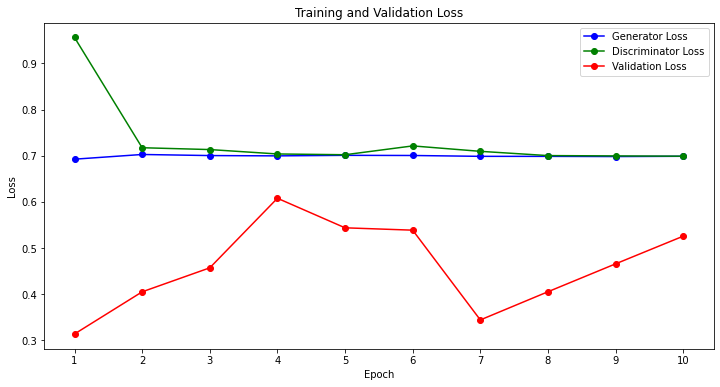

In [19]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 6)

plt.plot(df_stats['Training Loss generator'], 'b-o', label='Generator Loss')
plt.plot(df_stats['Training Loss discriminator'], 'g-o', label='Discriminator Loss')
plt.plot(df_stats['Valid. Loss'], 'r-o', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(df_stats.index)

plt.show()

In [20]:
best_transformer = BertModel.from_pretrained(model_name)
best_transformer.resize_token_embeddings(len(tokenizer))
best_transformer.load_state_dict(torch.load(transformer_path))
best_transformer.to(device)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31091, 768)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
   

In [21]:
best_discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)
best_discriminator.load_state_dict(torch.load(discriminator_path))
best_discriminator.to(device)

Discriminator(
  (input_dropout): Dropout(p=0.1, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (logit): Linear(in_features=768, out_features=4, bias=True)
  (softmax): Softmax(dim=-1)
)

In [22]:
def gan_bert_predict(transformer, discriminator, test_dataloader):
    
    transformer.eval()
    discriminator.eval()
    
    all_preds = []
    all_labels_ids = []
    all_filtered_logits = []
    
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
        all_filtered_logits += filtered_logits.detach().cpu()
        
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    all_filtered_logits = torch.stack(all_filtered_logits).numpy()
    
    return all_labels_ids, all_preds, all_filtered_logits

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_true, y_pred, probs = gan_bert_predict(best_transformer, best_discriminator, eval_dataloader)

usage_class_names = ['EXTEND', 'MENTION', 'NOTALGO', 'USE']
utilize_class_labels = ["NOTUTILIZE", "UTILIZE"]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print('Accuracy: %.5f%%' % (accuracy*100))
print('Precision: %.5f%%' % (precision*100))
print('Recall: %.5f%%' % (recall*100))
print('F1 Score: %.5f%%' % (f1*100))

print(classification_report(y_true, y_pred, target_names=utilize_class_labels, zero_division=0, digits=3))

Accuracy: 92.38636%
Precision: 81.99437%
Recall: 79.50880%
F1 Score: 80.67994%
              precision    recall  f1-score   support

  NOTUTILIZE      0.952     0.963     0.957       778
     UTILIZE      0.688     0.627     0.656       102

    accuracy                          0.924       880
   macro avg      0.820     0.795     0.807       880
weighted avg      0.921     0.924     0.922       880



In [24]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 2]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [25]:
import matplotlib.pyplot as plt

# evaluate_roc(probs, y_true-1)

In [26]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[733  45]
 [ 11  91]]


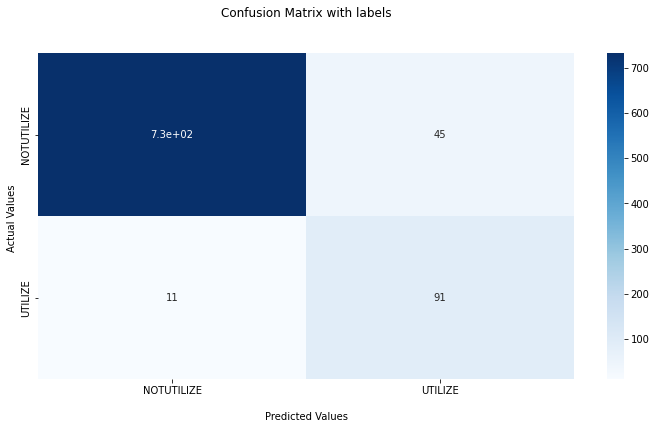

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(utilize_class_labels)
ax.yaxis.set_ticklabels(utilize_class_labels)

## Display the visualization of the Confusion Matrix.
plt.show()

In [28]:
inv_encoding = {v: k for k, v in label_map.items()}
pred_label = [inv_encoding[key] for key in y_pred]

In [29]:
def load_eval_dataset(fold=1, percentage=None):
    df = pd.read_csv(f'../spin-off/dataset/fold_{fold}/10-fold_original_{percentage}/algocite_utilize_dataset_test_fold_{fold}.csv')
    df['CITATIONS_CONTEXTS'] = df['CITATIONS_CONTEXTS'].str.replace(r"=-=[\S\s]+-=-", "<cite>", regex=True)
    X, y = df['CITATIONS_CONTEXTS'].values, df['UTILIZE_LABELS'].values
    return X, y

In [30]:
X_test, y_test = load_eval_dataset(fold=fold, percentage=percentage)
df_test = pd.DataFrame({'CITATIONS_CONTEXTS': X_test, 'UTILIZE_LABELS': y_test, 'PRED_LABELS': pred_label})
df_test

,CITATIONS_CONTEXTS,UTILIZE_LABELS,PRED_LABELS
0,he content of each pixel. These kinds of algor...,NOTUTILIZE,NOTUTILIZE
1,iagram. The proposed model includes validation...,NOTUTILIZE,NOTUTILIZE
2,plicity intervals are not redefined. We consid...,NOTUTILIZE,NOTUTILIZE
3,"y many prunings, a recent method developed in ...",NOTUTILIZE,NOTUTILIZE
4,on fault detectability [23]. A clock partition...,NOTUTILIZE,NOTUTILIZE
...,...,...,...
875,s in the barycentric Bernstein basis can be so...,NOTUTILIZE,UTILIZE
876,"[20], and the controller is calculated automat...",NOTUTILIZE,NOTUTILIZE
877,o be as large as the theoretical step. 4.4 Pol...,NOTUTILIZE,NOTUTILIZE
878,or vice versa. To aid in understanding the co-...,UTILIZE,UTILIZE


In [31]:
df_test.to_csv(f'./cls_results/GAN_SciBERT_original_UTILIZE_{percentage}_Fold_{fold}_100_unlabeled_new2.csv', index=False)